# Week 2_2: Implementing Locality Sensitive Hashing from scratch

Locality Sensitive Hashing (LSH) provides for a fast, efficient approximate nearest neighbor search. The algorithm scales well with respect to the number of data points as well as dimensions.

In this assignment, you will

- Implement the LSH algorithm for approximate nearest neighbor search
- Examine the accuracy for different documents by comparing against brute force search, and also contrast runtimes
- Explore the role of the algorithm’s tuning parameters in the accuracy of the method

In [1]:
import numpy as np                                             # dense matrices
import sframe                                                  # see below for install instruction
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.metrics.pairwise import pairwise_distances        # pairwise distances
from copy import copy                                          # deep copies
import matplotlib.pyplot as plt                                # plotting
%matplotlib inline

'''compute norm of a sparse vector
   Thanks to: Jaiyam Sharma'''
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return(norm)

[INFO] sframe.cython.cy_server: SFrame v2.1 started. Logging /tmp/sframe_server_1472715339.log
INFO:sframe.cython.cy_server:SFrame v2.1 started. Logging /tmp/sframe_server_1472715339.log


In [2]:
wiki = sframe.SFrame('people_wiki.gl/')
wiki = wiki.add_row_number()             # add row number, starting at 0

In [3]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)
    
corpus = load_sparse_csr('people_wiki_tf_idf.npz')

In [4]:
map_index_to_word = sframe.SFrame('people_wiki_map_index_to_word.gl/')

In [5]:
corpus.shape

(59071, 547979)

# train an LSH model

In [6]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

In [7]:
np.random.seed(0)
print generate_random_vectors(num_vector=3, dim=5)

[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323]]


* create 16 bins with dimmension = # of features

In [8]:
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
#print random_vectors

In [9]:
#doc = corpus[0, :]
#print doc.dot(random_vectors[:, 0]) >= 0

In [10]:
#print doc.dot(random_vectors[:, 1]) >= 0

In [11]:
#print doc.dot(random_vectors) >= 0 # should return an array of 16 True/False bits
#print np.array(doc.dot(random_vectors) >= 0, dtype=int) # display index bits in 0/1's

* encode the bin to 0 or 1

In [12]:
#print corpus[0:2].dot(random_vectors) >= 0 # compute bit indices of first two documents
print corpus.dot(random_vectors) >= 0 # compute bit indices of ALL documents

[[ True  True False ...,  True False  True]
 [ True False False ..., False False  True]
 [False  True False ...,  True False  True]
 ..., 
 [ True  True False ...,  True  True  True]
 [False  True  True ...,  True False  True]
 [ True False  True ..., False False  True]]


* convert the power of 2

In [13]:
#doc = corpus[0, :]  # first document
#index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
#print index_bits
#print powers_of_two           # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
#print index_bits.dot(powers_of_two)

* sum up each bin to be a number

In [14]:
index_bits = corpus.dot(random_vectors) >= 0
print index_bits.dot(powers_of_two)

[50917 36265 19365 ..., 52983 27589 41449]


In [15]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] = [] # YOUR CODE HERE
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        table[bin_index].append(data_index) # YOUR CODE HERE

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

In [16]:
# Checkpoint
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print 'Passed!'
else:
    print 'Check your code.'

Passed!


# Inspect bins

In [17]:
print wiki[wiki['name'] == 'Barack Obama']

+-------+-------------------------------+--------------+
|   id  |              URI              |     name     |
+-------+-------------------------------+--------------+
| 35817 | <http://dbpedia.org/resour... | Barack Obama |
+-------+-------------------------------+--------------+
+-------------------------------+
|              text             |
+-------------------------------+
| barack hussein obama ii br... |
+-------------------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


In [18]:
# Obama's bin integer index
model['bin_indices'][35817]

50194

# Quiz Question. Examine the bit representations of the bins containing Barack Obama and Joe Biden. In how many places do they agree?

In [19]:
print wiki[wiki['name']=='Joe Biden']

+-------+-------------------------------+-----------+
|   id  |              URI              |    name   |
+-------+-------------------------------+-----------+
| 24478 | <http://dbpedia.org/resour... | Joe Biden |
+-------+-------------------------------+-----------+
+-------------------------------+
|              text             |
+-------------------------------+
| joseph robinette joe biden... |
+-------------------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


In [20]:
agree = model['bin_index_bits'][35817] == model['bin_index_bits'][24478]
agree.sum()

14

In [21]:
#print wiki[wiki['name']=='Wynn Normington Hugh-Jones']

#np.array(model['bin_index_bits'][22745], dtype=int) # list of 0/1's
agree2 = model['bin_index_bits'][35817] == model['bin_index_bits'][22745]
agree2.sum()

8

In [22]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama

docs = wiki.filter_by(values=doc_ids, column_name='id') # filter by id column
print docs

+-------+-------------------------------+-------------------------+
|   id  |              URI              |           name          |
+-------+-------------------------------+-------------------------+
| 21426 | <http://dbpedia.org/resour... |      Mark Boulware      |
| 39426 | <http://dbpedia.org/resour... | John Wells (politician) |
| 50261 | <http://dbpedia.org/resour... |    Francis Longstaff    |
| 53937 | <http://dbpedia.org/resour... |  Madurai T. Srinivasan  |
+-------+-------------------------------+-------------------------+
+-------------------------------+
|              text             |
+-------------------------------+
| mark boulware born 1948 is... |
| sir john julius wells born... |
| francis a longstaff born a... |
| maduraitsrinivasan is a we... |
+-------------------------------+
[4 rows x 4 columns]



In [23]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print '================= Cosine distance from Barack Obama'
print 'Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf))
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print 'Barack Obama - {0:24s}: {1:f}'.format(wiki[doc_id]['name'],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


# Query the LSH model

In [24]:
from itertools import combinations

num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius):
    print diff

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

In [25]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = not query_bin_bits[i] # YOUR CODE HERE 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            candidate_list = list(candidate_set) + list(table[nearby_bin]) # YOUR CODE HERE: Update candidate_set with the documents in this bin.
            candidate_set = set(candidate_list)
            
    return candidate_set

* Quiz Question. What was the smallest search radius that yielded the correct nearest neighbor, namely Joe Biden

In [27]:
# Checkpoint
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print 'Passed test'
else:
    print 'Check your code'
print 'List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261'

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


In [28]:
# Checkpoint
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print 'Passed test'
else:
    print 'Check your code'

Passed test


# calculate the distance

In [29]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in xrange(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = sframe.SFrame({'id':candidate_set})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True), len(candidate_set)

In [30]:
print query(corpus[35817,:], model, k=10, max_search_radius=3)

(Columns:
	id	int
	distance	float

Rows: 10

Data:
+-------+--------------------+
|   id  |      distance      |
+-------+--------------------+
| 35817 | -6.66133814775e-16 |
| 24478 |   0.703138676734   |
| 56008 |   0.856848127628   |
| 37199 |   0.874668698194   |
| 40353 |   0.890034225981   |
|  9267 |   0.898377208819   |
| 55909 |   0.899340396322   |
|  9165 |   0.900921029925   |
| 57958 |   0.903003263483   |
| 49872 |   0.909532800353   |
+-------+--------------------+
[10 rows x 2 columns]
, 727)


In [31]:
result, num_candidates_considered = query(corpus[35817,:], model, k=10, max_search_radius=3)
print result.join(wiki[['id', 'name']], on='id').sort('distance')

+-------+--------------------+-------------------------+
|   id  |      distance      |           name          |
+-------+--------------------+-------------------------+
| 35817 | -6.66133814775e-16 |       Barack Obama      |
| 24478 |   0.703138676734   |        Joe Biden        |
| 56008 |   0.856848127628   |      Nathan Cullen      |
| 37199 |   0.874668698194   | Barry Sullivan (lawyer) |
| 40353 |   0.890034225981   |      Neil MacBride      |
|  9267 |   0.898377208819   |   Vikramaditya Khanna   |
| 55909 |   0.899340396322   |       Herman Cain       |
|  9165 |   0.900921029925   |   Raymond F. Clevenger  |
| 57958 |   0.903003263483   |    Michael J. Malbin    |
| 49872 |   0.909532800353   |      Lowell Barron      |
+-------+--------------------+-------------------------+
[10 rows x 3 columns]



# Experimenting with your LSH implementation

* Effect of nearby bin search

In [32]:
import time

num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in xrange(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
    
    print 'Radius:', max_search_radius
    # Display 10 nearest neighbors, along with document ID and name
    print result.join(wiki[['id', 'name']], on='id').sort('distance')
    
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
+-------+--------------------+-------------------------+
|   id  |      distance      |           name          |
+-------+--------------------+-------------------------+
| 35817 | -6.66133814775e-16 |       Barack Obama      |
| 21426 |   0.950866757525   |      Mark Boulware      |
| 39426 |   0.97596600411    | John Wells (politician) |
| 50261 |   0.978256163041   |    Francis Longstaff    |
| 53937 |   0.993092148424   |  Madurai T. Srinivasan  |
+-------+--------------------+-------------------------+
[5 rows x 3 columns]

Radius: 1
+-------+--------------------+-------------------------------+
|   id  |      distance      |              name             |
+-------+--------------------+-------------------------------+
| 35817 | -6.66133814775e-16 |          Barack Obama         |
| 41631 |   0.947459482005   |          Binayak Sen          |
| 21426 |   0.950866757525   |         Mark Boulware         |
| 33243 |   0.951765770113   |        Janice Lachance        |
| 33

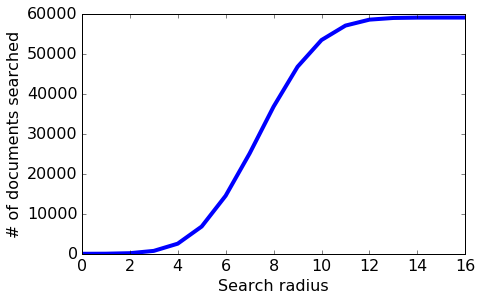

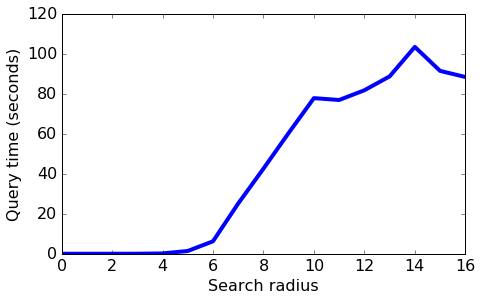

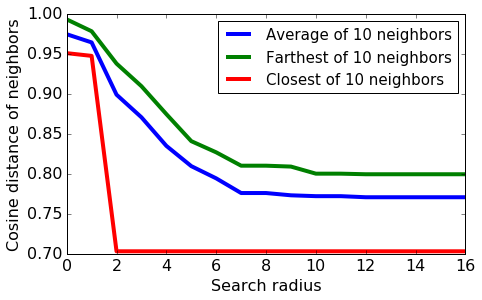

In [33]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

* Quiz Question. What was the smallest search radius that yielded the correct nearest neighbor, namely Joe Biden?

* Answer: radius = 2

* Quiz Question. Suppose our goal was to produce 10 approximate nearest neighbors whose average distance from the query document is within 0.01 of the average for the true 10 nearest neighbors. For Barack Obama, the true 10 nearest neighbors are on average about 0.77. What was the smallest search radius for Barack Obama that produced an average distance of 0.78 or better?
* Answer: 

* Quality metrics for neighbors



In [41]:
average_distance_from_query_history

[0.9745452682750879,
 0.9642887060258672,
 0.8989583845830388,
 0.8706516030485052,
 0.8349346493308571,
 0.8096145239653254,
 0.7943131453905066,
 0.7759826058523335,
 0.7759826058523335,
 0.7731349875446498,
 0.772070052411731,
 0.772070052411731,
 0.7707191289494766,
 0.7707191289494766,
 0.7707191289494766,
 0.7707191289494766,
 0.7707191289494766]

In [34]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = sframe.SFrame({'id':range(num_data_points)})
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True)

In [35]:
max_radius = 17
precision = {i:[] for i in xrange(max_radius)}
average_distance  = {i:[] for i in xrange(max_radius)}
query_time  = {i:[] for i in xrange(max_radius)}


np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors
    
    for r in xrange(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()
        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result['id']) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


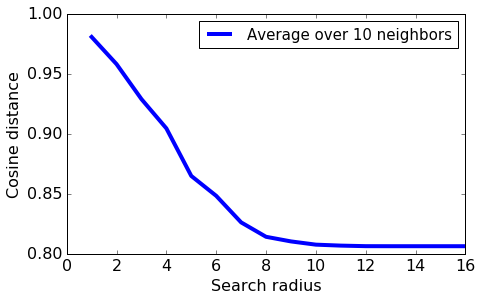

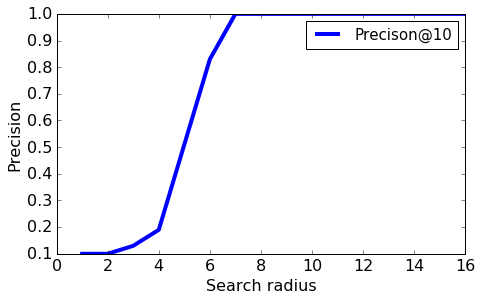

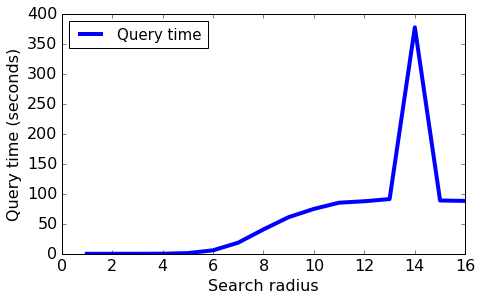

In [36]:


plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in xrange(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in xrange(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in xrange(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

* Effect of number of random vectors

In [37]:
precision = {i:[] for i in xrange(5,20)}
average_distance  = {i:[] for i in xrange(5,20)}
query_time = {i:[] for i in xrange(5,20)}
num_candidates_history = {i:[] for i in xrange(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors

for num_vector in xrange(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


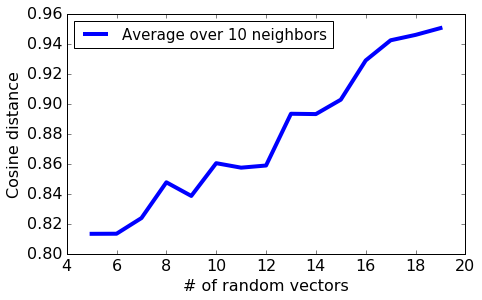

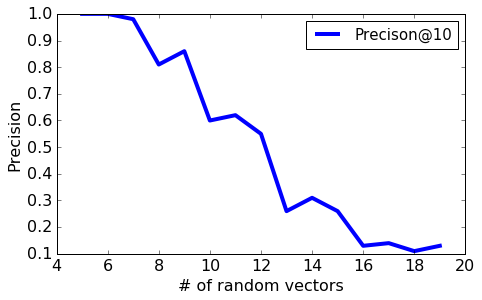

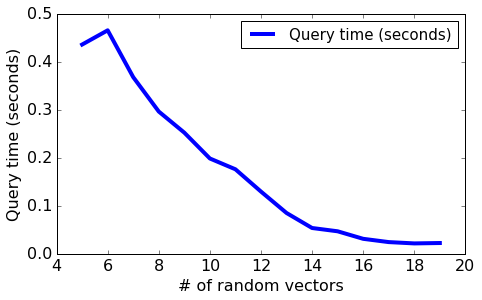

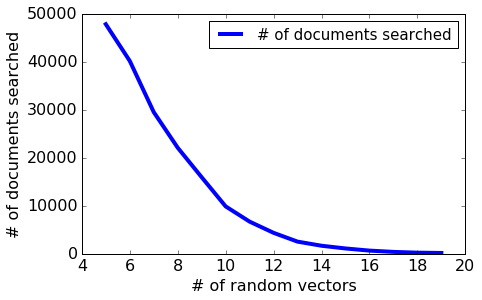

In [38]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in xrange(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in xrange(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in xrange(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in xrange(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()